## RNA Velocity using scVelo
Marissa Esteban

Data: CITEseq from OWHA atalas

I did pre processing in Suerat and saved object as .h5Seurat to perform RNAvelo in Python wtih scVelo

In [1]:
# Setup
import scanpy as sc
import scvelo as scv
import anndata
import loompy
import mygene
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:

h5ad_path = "/Volumes/PortableSSD/IntegratedMultimodal_CITEseq.h5ad"
adata = sc.read_h5ad(h5ad_path)
adata.obs.index = [x.split('-')[0] for x in adata.obs.index]    # TTTGGAGTCGGTTGTA-1_1

loom_paths = ["/Volumes/PortableSSD/YS001/possorted_genome_bam_KLWV0.loom",
              "/Volumes/PortableSSD/YS002/possorted_genome_bam_PNEM4.loom",
              "/Volumes/PortableSSD/YS003/possorted_genome_bam_8Q2XV.loom",
              "/Volumes/PortableSSD/YS004/possorted_genome_bam_0XB2N.loom",
              "/Volumes/PortableSSD/YS005/possorted_genome_bam_HX08G.loom",
              "/Volumes/PortableSSD/YS006/possorted_genome_bam_751VB.loom"]
combined_loom_path = "/Volumes/PortableSSD/citeseq_combined.loom"

loompy.combine(loom_paths, combined_loom_path)
ldata = sc.read_loom(combined_loom_path)
ldata.obs.index = [x.split(':')[1] for x in ldata.obs.index]    # possorted_genome_bam_751VB:AAAGTCCGTAAGGTCGx
ldata.obs.index = [x[:-1] for x in ldata.obs.index] 

### SANITY CHECKING

- inspecting andata and ldata objects (cell and gene counts)
- checking for duplicates

In [4]:
print("=== Seurat-derived AnnData (adata) ===")
print("Cells (obs):", adata.n_obs)
print("Genes (var):", adata.n_vars)
print("\nFirst 10 cell names:", adata.obs.index[:10].tolist())
print("\nFirst 10 gene names:", adata.var.index[:10].tolist())

print("\n\n=== Loom RNA velocity AnnData (ldata) ===")
print("Cells (obs):", ldata.n_obs)
print("Genes (var):", ldata.n_vars)
print("\nFirst 10 cell names:", ldata.obs.index[:10].tolist())
print("\nFirst 10 gene names:", ldata.var.index[:10].tolist())

print("\n\n=== Layer shapes in ldata ===")
for layer in ["spliced", "unspliced", "ambiguous"]:
    if layer in ldata.layers:
        print(f"{layer}: {ldata.layers[layer].shape}")



# check for duplicates in adata and ladata
print("\n\n=== Checking for dupicates ===")
print("Total cells in adata:", len(adata.obs.index))
print("Unique cells in adata:", len(adata.obs.index.unique()))
print("Duplicate barcodes in adata:", len(adata.obs.index) - len(adata.obs.index.unique()))

print("\nTotal cells in ldata:", len(ldata.obs.index))
print("Unique cells in ldata:", len(ldata.obs.index.unique()))
print("Duplicate barcodes in ldata:", len(ldata.obs.index) - len(ldata.obs.index.unique()))

# Show some duplicates if they exist
from collections import Counter
adata_counts = Counter(adata.obs.index)
adata_duplicates = {bc: count for bc, count in adata_counts.items() if count > 1}
print(f"\nNumber of duplicated barcodes: {len(adata_duplicates)}")
if adata_duplicates:
    print("Examples:", list(adata_duplicates.items())[:5])


=== Seurat-derived AnnData (adata) ===
Cells (obs): 35317
Genes (var): 30481

First 10 cell names: ['AAACCCAAGAACAGGA', 'AAACCCAAGTCTCTGA', 'AAACGAAAGACTACGG', 'AAACGAAAGATTCGCT', 'AAACGAAAGCTCACTA', 'AAACGAACAGCTGTAT', 'AAACGAACATCCTTGC', 'AAACGAAGTACTGACT', 'AAACGAAGTGTATCCA', 'AAACGAAGTTGCTCGG']

First 10 gene names: ['Xkr4', 'Gm19938', 'Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h', 'Npbwr1', '4732440D04Rik']


=== Loom RNA velocity AnnData (ldata) ===
Cells (obs): 45487
Genes (var): 33696

First 10 cell names: ['AAAGGGCAGTCATACC', 'AAAGGTATCGGAAGGT', 'AAATGGACACTCAAGT', 'AAAGAACCAGTTGTTG', 'AAACGAACATCCTTGC', 'AAAGGATTCCAATCTT', 'AAATGGAAGTGGAAAG', 'AAAGTCCAGAACGCGT', 'AAAGTGAGTCACGTGC', 'AAAGGGCGTTGTCTAG']

First 10 gene names: ['ENSMUSG00000079800', 'ENSMUSG00000095092', 'ENSMUSG00000079794', 'ENSMUSG00000079192', 'ENSMUSG00000094799', 'ENSMUSG00000095250', 'ENSMUSG00000095787', 'ENSMUSG00000095672', 'ENSMUSG00000094514', 'ENSMUSG00000096100']


=== Layer shapes in lda

In [5]:
# Remove duplicates from both datasets (keep first occurrence)
print("\n=== Removing duplicates ===")
adata = adata[~adata.obs.index.duplicated(keep='first'), :]
ldata = ldata[~ldata.obs.index.duplicated(keep='first'), :]

print(f"adata after dedup: {adata.shape}")
print(f"ldata after dedup: {ldata.shape}")

# Find common barcodes
common_barcodes = set(adata.obs.index).intersection(set(ldata.obs.index))
print(f"\n=== Common cells ===")
print(f"Cells in common: {len(common_barcodes)}")

# Subset both datasets to only common cells
# Convert to list and sort for reproducibility
common_barcodes = sorted(list(common_barcodes))

adata = adata[common_barcodes, :]
ldata = ldata[common_barcodes, :]

print(f"\n=== Final datasets ===")
print(f"Final adata shape: {adata.shape}")
print(f"Final ldata shape: {ldata.shape}")
print(f"Indices match: {all(adata.obs.index == ldata.obs.index)}")


=== Removing duplicates ===
adata after dedup: (35173, 30481)
ldata after dedup: (45252, 33696)

=== Common cells ===
Cells in common: 34946

=== Final datasets ===
Final adata shape: (34946, 30481)
Final ldata shape: (34946, 33696)
Indices match: True


In [6]:
# converting the loom's ENSEMBL ID's to match 

mg = mygene.MyGeneInfo()
gene_index = ldata.var.index.to_series()

# only grab the genes that have ENSEMBL IDs
is_ensembl = gene_index.str.startswith("ENSMUSG")

print("Total genes:", gene_index.shape[0])
print("ENSEMBL-like genes:", is_ensembl.sum())
print("Already-symbol-like genes:", (~is_ensembl).sum(), '\n')

# only query the ENSMUSG IDs
ens_ids = gene_index[is_ensembl].unique().tolist()

results = mg.querymany(
    ens_ids,
    scopes="ensemblgene",   # or "ensembl.gene" depending on mygene version, but this usually works
    fields="symbol",
    species="mouse",
    as_dataframe=False
)

# Build mapping dict ENSMUSG -> symbol
ens_to_symbol = {r["query"]: r.get("symbol", None) for r in results}

# QC on mapping
total_ens = len(ens_ids)
mapped_ens = sum(v is not None for v in ens_to_symbol.values())
print("Total ENSMUSG IDs:", total_ens)
print("Mapped ENSMUSG → symbol:", mapped_ens)
print("Unmapped ENSMUSG:", total_ens - mapped_ens)

# 4) Create a 'symbol' column:
# default: keep existing name
ldata.var["symbol"] = gene_index.copy()

# replace ENSMUSG entries with their symbol
for g in gene_index[is_ensembl]:
    sym = ens_to_symbol.get(g, None)
    if sym is not None:
        ldata.var.at[g, "symbol"] = sym


ldata.var.index = ldata.var["symbol"]

gene_index = ldata.var.index.to_series()
is_ensembl = gene_index.str.startswith("ENSMUSG")

print("Total ENSMUSG IDs after mapping: ", is_ensembl.sum())

INFO:biothings.client:querying 1-248 ...


Total genes: 33696
ENSEMBL-like genes: 248
Already-symbol-like genes: 33448 



INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Total ENSMUSG IDs: 248
Mapped ENSMUSG → symbol: 203
Unmapped ENSMUSG: 45
Total ENSMUSG IDs after mapping:  45


In [7]:
# Intersect with Seurat genes
ldata.var_names_make_unique()  # This handles any duplicate gene symbol

print("Total number of var names: ", len(adata.var_names))

# Now find common genes between the two datasets
common_genes = adata.var.index.intersection(ldata.var.index)
print("Overlapping genes after symbol mapping:", len(common_genes))

# Subset both datasets to common genes
adata_subset = adata[:, common_genes].copy()
ldata_subset = ldata[:, common_genes].copy()

print(f"adata shape: {adata_subset.shape}")
print(f"ldata shape: {ldata_subset.shape}")

Total number of var names:  30481
Overlapping genes after symbol mapping: 29365
adata shape: (34946, 29365)
ldata shape: (34946, 29365)


In [8]:
# Sanity Checks

# Verify cell barcodes match
print("Cells match:", (adata_subset.obs.index == ldata_subset.obs.index).all())

# If they don't match, reorder ldata_subset to match adata_subset:
ldata_subset = ldata_subset[adata_subset.obs.index, :].copy()

# Double-check genes are in same order
print("Genes match:", (adata_subset.var.index == ldata_subset.var.index).all())

Cells match: True
Genes match: True


### Integrating Loom and OWHA object

In [9]:
# Add velocity layers to adata_subset
adata_subset.layers["spliced"] = ldata_subset.layers["spliced"].copy()
adata_subset.layers["unspliced"] = ldata_subset.layers["unspliced"].copy()
adata_subset.layers["ambiguous"] = ldata_subset.layers["ambiguous"].copy()

# Verify they were added
print("Layers in adata_subset:", list(adata_subset.layers.keys()))
print("Spliced shape:", adata_subset.layers["spliced"].shape)
print("Unspliced shape:", adata_subset.layers["unspliced"].shape)

Layers in adata_subset: ['spliced', 'unspliced', 'ambiguous']
Spliced shape: (34946, 29365)
Unspliced shape: (34946, 29365)


In [10]:
adata_subset.obs

orig.ident  nCount_RNA  nFeature_RNA      timepoint  \
AAACCCAAGAACAGGA     UW_CITEseq_1      4246.0          1723      Unwounded   
AAACCCAAGATACAGT  D30PW_CITEseq_1      5424.0          2026  Wounded_D30PW   
AAACCCAAGCAATAGT  D15PW_CITEseq_2      5251.0          1547  Wounded_D15PW   
AAACCCAAGCGCCTAC  D15PW_CITEseq_2      6564.0          2217  Wounded_D15PW   
AAACCCAAGCTAGTTC  D15PW_CITEseq_1      6762.0          2138  Wounded_D15PW   
...                           ...         ...           ...            ...   
TTTGTTGTCTCAGTCC  D30PW_CITEseq_1     16213.0          3284  Wounded_D30PW   
TTTGTTGTCTCTGCTG  D30PW_CITEseq_2     15672.0          4255  Wounded_D30PW   
TTTGTTGTCTGCGAGC  D15PW_CITEseq_2     14728.0          3067  Wounded_D15PW   
TTTGTTGTCTGGAAGG  D15PW_CITEseq_1      5141.0          1741  Wounded_D15PW   
TTTGTTGTCTGGTGGC  D15PW_CITEseq_1      3119.0          1472  Wounded_D15PW   

                  nCount_ADT  nFeature_ADT  percent_mito  percent_ribo  \
AAACCCAAGAACAGGA       399.0            78      8.431465      6.947715   
AAACCCAAGATACAGT       239.0            69      5.530973      6.526549   
AAACCCAAGCAATAGT      1507.0            98      1.256903     26.128357   
AAACCCAAGCGCCTAC      1846.0            99      1.416819     12.568556   
AAACCCAAGCTAGTTC      1862.0           100      1.286602     12.407572   
...                      ...           ...           ...           ...   
TTTGTTGTCTCAGTCC       260.0            66      1.443286     32.757664   
TTTGTTGTCTCTGCTG       628.0            85      3.088310     24.183257   
TTTGTTGTCTGCGAGC      1545.0           101      2.783813     27.206681   
TTTGTTGTCTGGAAGG      1740.0            97      1.225443      0.641898   
TTTGTTGTCTGGTGGC      1602.0            98      1.090093      9.009298   

                     timepoint_modality  nCount_SCT  ...    gptcelltype  \
AAACCCAAGAACAGGA      Unwounded_CITEseq      8358.0  ...    Fibroblasts   
AAACCCAAGATACAGT  Wounded_D30PW_CITEseq      7201.0  ...  Keratinocytes   
AAACCCAAGCAATAGT  Wounded_D15PW_CITEseq      6036.0  ...  Keratinocytes   
AAACCCAAGCGCCTAC  Wounded_D15PW_CITEseq      6529.0  ...  Keratinocytes   
AAACCCAAGCTAGTTC  Wounded_D15PW_CITEseq      6697.0  ...    Fibroblasts   
...                                 ...         ...  ...            ...   
TTTGTTGTCTCAGTCC  Wounded_D30PW_CITEseq      8354.0  ...  Keratinocytes   
TTTGTTGTCTCTGCTG  Wounded_D30PW_CITEseq      5257.0  ...  Schwann cells   
TTTGTTGTCTGCGAGC  Wounded_D15PW_CITEseq      6825.0  ...        Unknown   
TTTGTTGTCTGGAAGG  Wounded_D15PW_CITEseq      5966.0  ...  Keratinocytes   
TTTGTTGTCTGGTGGC  Wounded_D15PW_CITEseq      6053.0  ...  Keratinocytes   

                             sctype_skinDB           singleR  \
AAACCCAAGAACAGGA             Cycling cells    Cardiomyocytes   
AAACCCAAGATACAGT             Cycling cells           Neurons   
AAACCCAAGCAATAGT                   Unknown           T cells   
AAACCCAAGCGCCTAC             Schwann cells         Microglia   
AAACCCAAGCTAGTTC                   Unknown         Microglia   
...                                    ...               ...   
TTTGTTGTCTCAGTCC  Suprabasal Keratinocytes           B cells   
TTTGTTGTCTCTGCTG             Cycling cells      Erythrocytes   
TTTGTTGTCTGCGAGC  Suprabasal Keratinocytes  Oligodendrocytes   
TTTGTTGTCTGGAAGG               Fibroblasts        Astrocytes   
TTTGTTGTCTGGTGGC               Macrophages         Microglia   

                                     celltype      celltype_fine  \
AAACCCAAGAACAGGA                    Pericytes        Pericyte II   
AAACCCAAGATACAGT             HF Keratinocytes             IRS II   
AAACCCAAGCAATAGT              Dendritic cells               cDC2   
AAACCCAAGCGCCTAC                  Macrophages     Neutrophils II   
AAACCCAAGCTAGTTC                  Macrophages    Macrophages III   
...                                       ...                ...   
TTTGTTGTCTCAGTCC            IFE Keratinocytes      

In [11]:
adata_subset.layers.keys()


KeysView(Layers with keys: spliced, unspliced, ambiguous)

## Starting RNA Velocity!

Now that we have combined the .loom file with our exported Seurat object (now AnnData object) we can explore with RNA Velocity

In [12]:
adata_subset.obsm.keys()


KeysView(AxisArrays with keys: X_cca, X_harmony, X_pca, X_rpca, X_umap.cca, X_umap.harmony, X_umap.pca, X_umap.rpca)

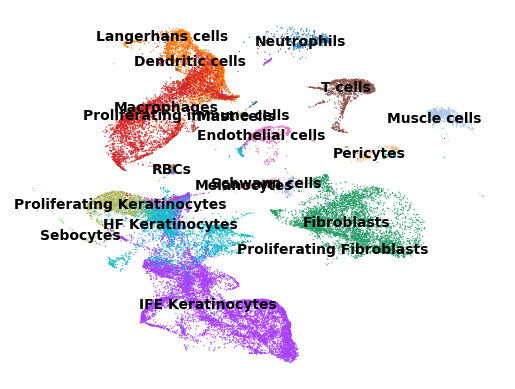

In [13]:
# plot umap to check
adata_subset.obsm["X_umap"] = adata_subset.obsm["X_umap.rpca"].copy()

sc.pl.umap(adata_subset, color="celltype", frameon=False,
           legend_loc='on data', title='', save='_celltypes_rpca.pdf')


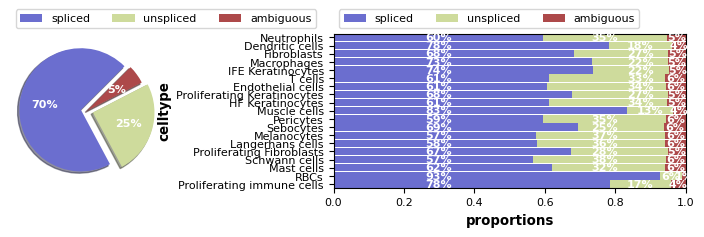

In [14]:
scv.pl.proportions(adata_subset, groupby='celltype')


In [15]:
adata_subset.obsm["X_pca"].shape


(34946, 50)

In [16]:
# pre-process
scv.pp.filter_and_normalize(adata_subset, min_shared_counts=20)
sc.pp.highly_variable_genes(adata_subset, n_top_genes=2000)

# subset to HVGs
adata_hvg = adata_subset[:, adata_subset.var['highly_variable']].copy()

# recompute neighbors on HVG PCA
scv.pp.moments(adata_hvg, n_pcs=30, n_neighbors=30)

Filtered out 17472 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Logarithmized X.


/var/folders/hq/r4mfshzj3dq22fq4382_72qw0000gp/T/ipykernel_20518/1409331441.py:9: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata_hvg, n_pcs=30, n_neighbors=30)
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [17]:
# compute velocity ( this step will take a while )
try:
    scv.tl.recover_dynamics(adata_hvg, n_top_genes=500)
    scv.tl.velocity(adata_hvg, mode='dynamical')
    scv.tl.velocity_graph(adata_hvg)
except Exception as e:
    print("Error while fitting dynamics:", e)
    print("Current gene index:", adata_hvg.var_names[adata_hvg.var['fit_alpha'].isna()].tolist()[:10])

recovering dynamics (using 1/16 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:11:37) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)
    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

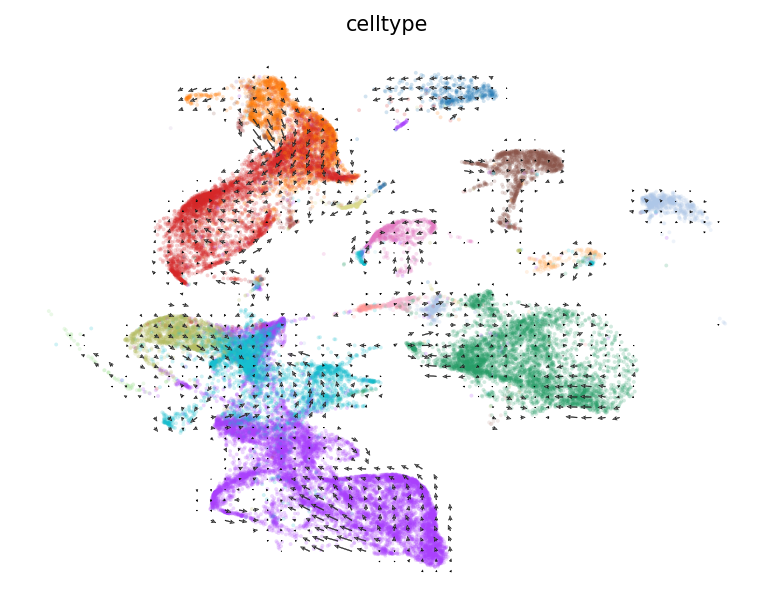

In [18]:
scv.pl.velocity_embedding_grid(
    adata_hvg,
    basis='X_umap',     
    color='celltype',
    dpi=150
)


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

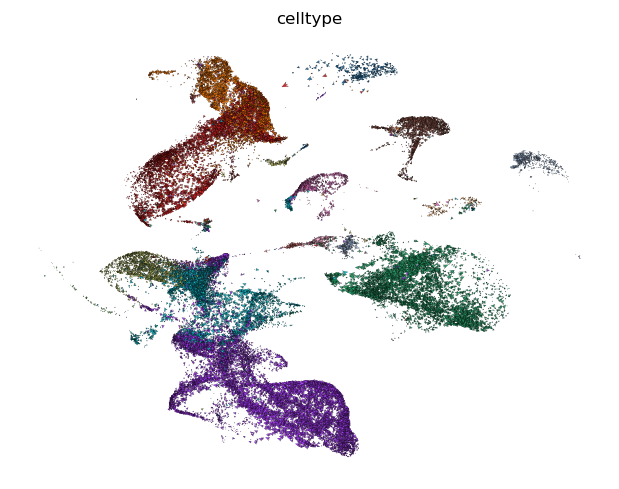

In [19]:
scv.pl.velocity_embedding(adata_hvg, 
                          arrow_length=3, 
                          arrow_size=2, 
                          color='celltype',
                          dpi=120)

In [20]:
scv.tl.rank_velocity_genes(adata_hvg, groupby='celltype')
df = scv.get_df(adata_hvg.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/tools/utils.py:463: DeprecationWarning: Please import `rankdata` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import rankdata


    finished (0:00:06) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


/var/folders/hq/r4mfshzj3dq22fq4382_72qw0000gp/T/ipykernel_20518/2477482753.py:2: DeprecationWarning: `get_df` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please `AnnData::get_df` or Scanpy's `scanpy.get.obs_df` or `scanpy.get.var_df`.
  df = scv.get_df(adata_hvg.uns['rank_velocity_genes']['names'])


Neutrophils Dendritic cells Fibroblasts Macrophages IFE Keratinocytes  \
0      Laptm5           Basp1        Ugdh       Basp1             Anxa1   
1        Crem            Plek         Dst       Itgb2          Serpinb2   
2      Tm6sf1            Crem       Fgfr1     Emilin2             Plet1   
3      Epsti1           Itgb2       Fstl1     Slc15a3              Fosb   
4       Soat1         Lilrb4b        Dab2      Lgals3             Epha4   

  T cells Endothelial cells Proliferating Keratinocytes HF Keratinocytes  \
0    Lcp2             Mef2c                       Itga6            Hspg2   
1  Tm6sf1              Nid1                       Lamc1            Anxa8   
2   Sp100              Rgl1                      Slc7a8            Lamc1   
3  Samhd1              Ebf1                       Creb5            Creb5   
4  Ms4a4c              Cd34                       Hspg2            Itga6   

  Muscle cells Pericytes Sebocytes Melanocytes Langerhans cells  \
0         Actb     Lamc1     Itga6      Zbtb20             Pkib   
1          Mt1    Zbtb20     Anxa8        Rgl1             Ctsc   
2          Vim  Serpine1     Timp3     Pcolce2             Crem   
3       Col6a2    Col5a2  Serpinb5        Nid1          Tnfaip2   
4      Pcolce2     Fstl1     Gata3      Rassf3             Hexa   

  Proliferating Fibroblasts Schwann cells Mast cells     RBCs  \
0                     Fstl1          Nid1     Lgals1   Csf2ra   
1                     Fgfr1        Col5a2       Pdpn     Actb   
2                    Zbtb20        Zbtb20       Hexa      Mt1   
3                    Col5a2        Col6a2      Man1a  Tnfaip2   
4                       Axl         Lama2       Ctsc     Ly86   

  Proliferating immune cells  
0                      Basp1  
1                       Crem  
2                      Itgb2  
3                     Cd300a  
4                       Plek

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

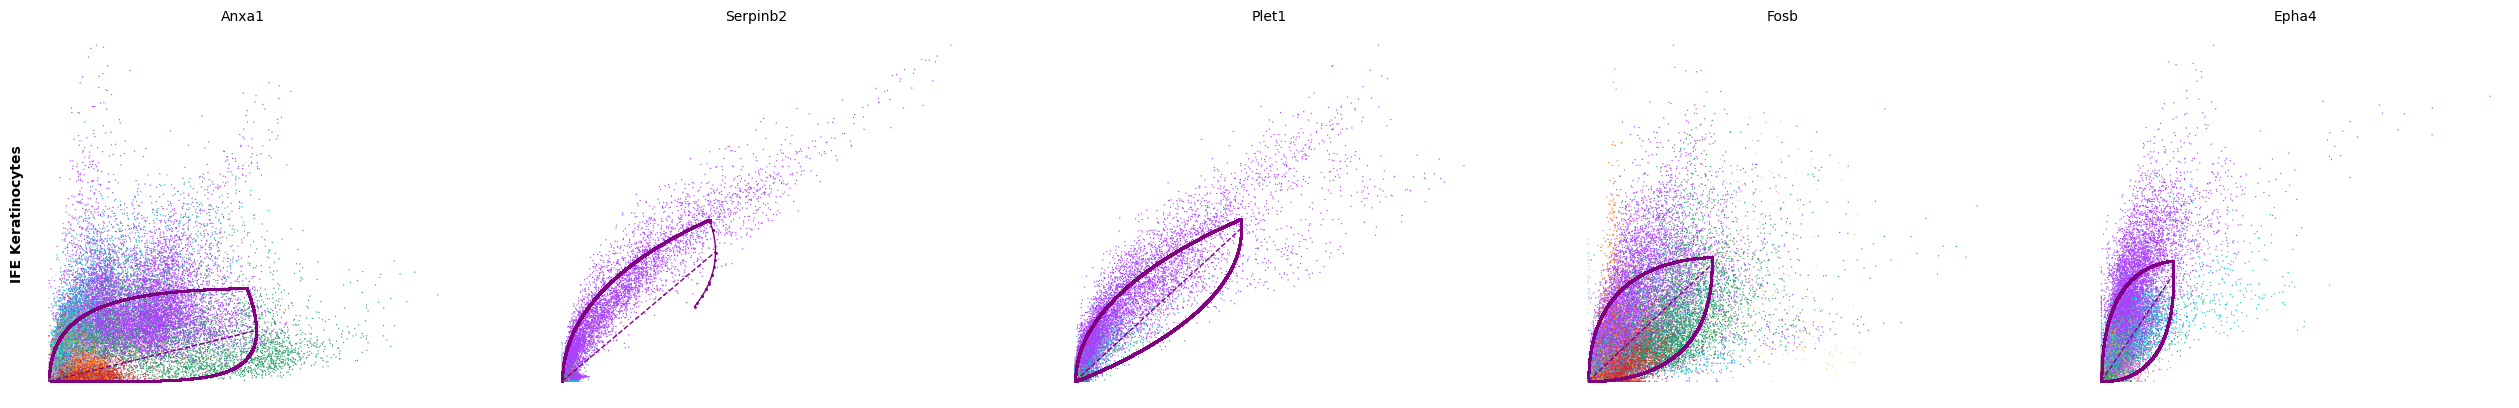

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

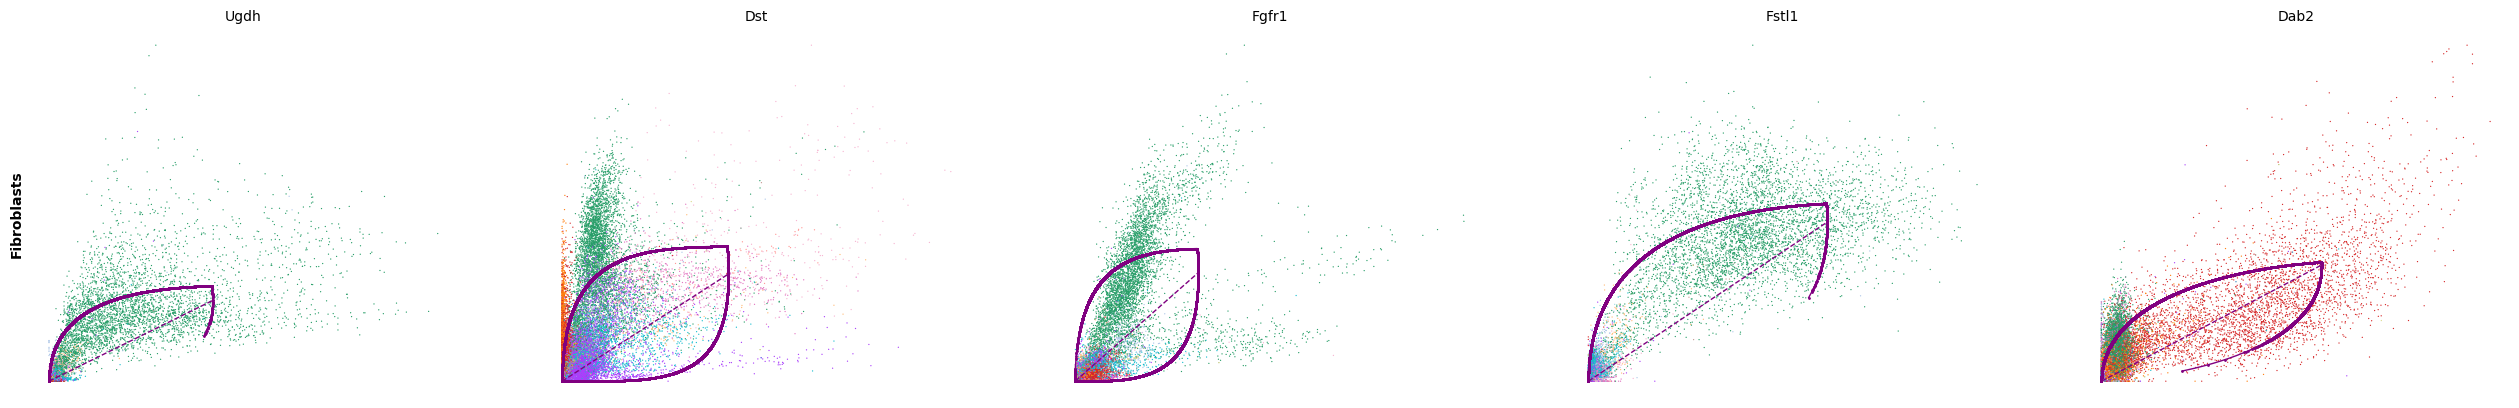

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

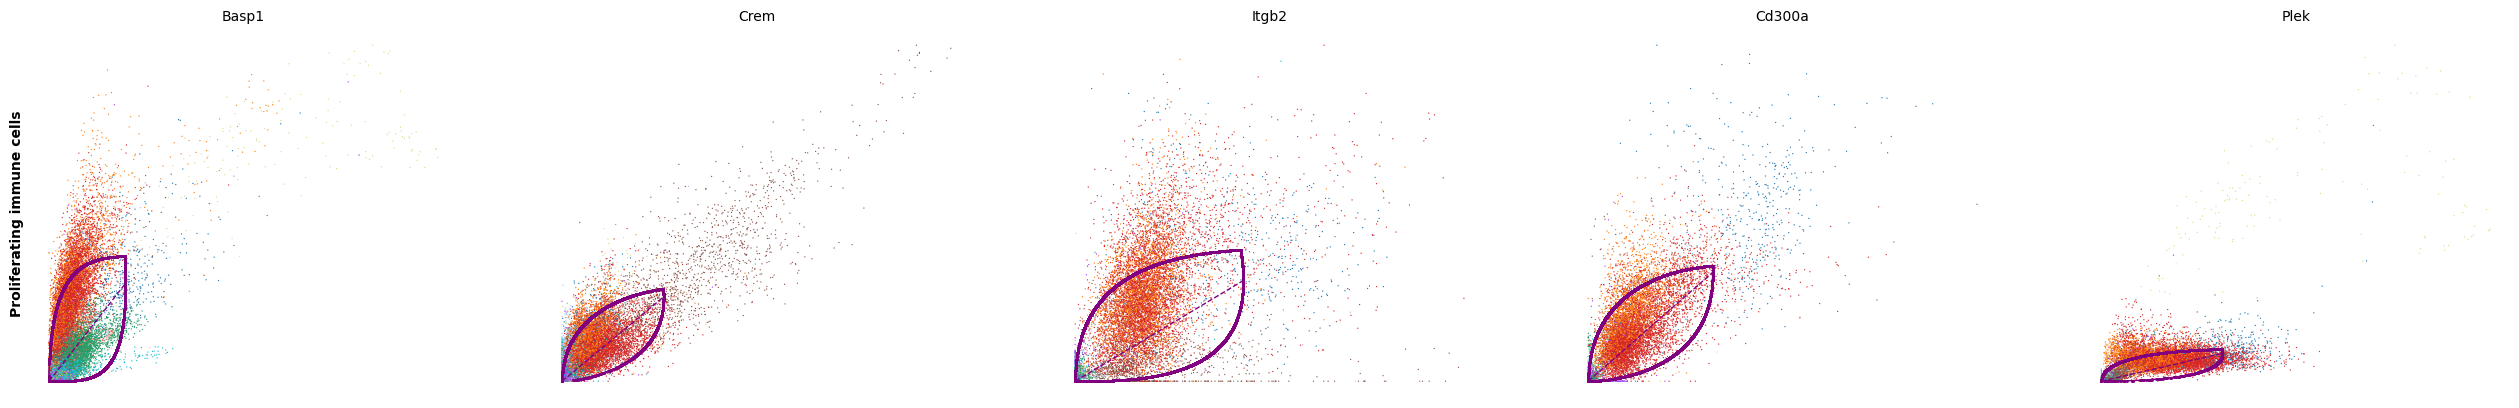

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

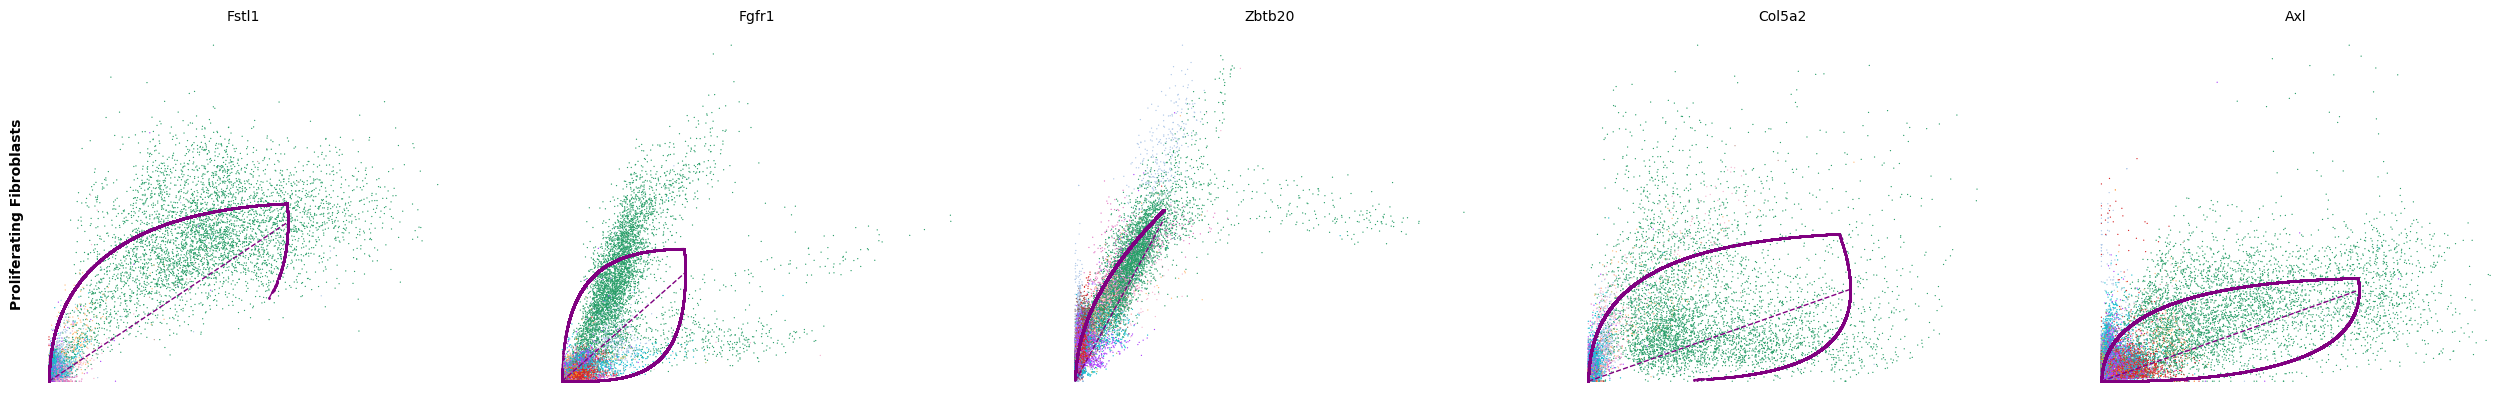

In [21]:
for cluster in ['IFE Keratinocytes', 'Fibroblasts', 'Proliferating immune cells', 'Proliferating Fibroblasts']:
    scv.pl.scatter(adata_hvg, df[cluster][:5], ylabel=cluster, frameon=False, color='celltype')

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

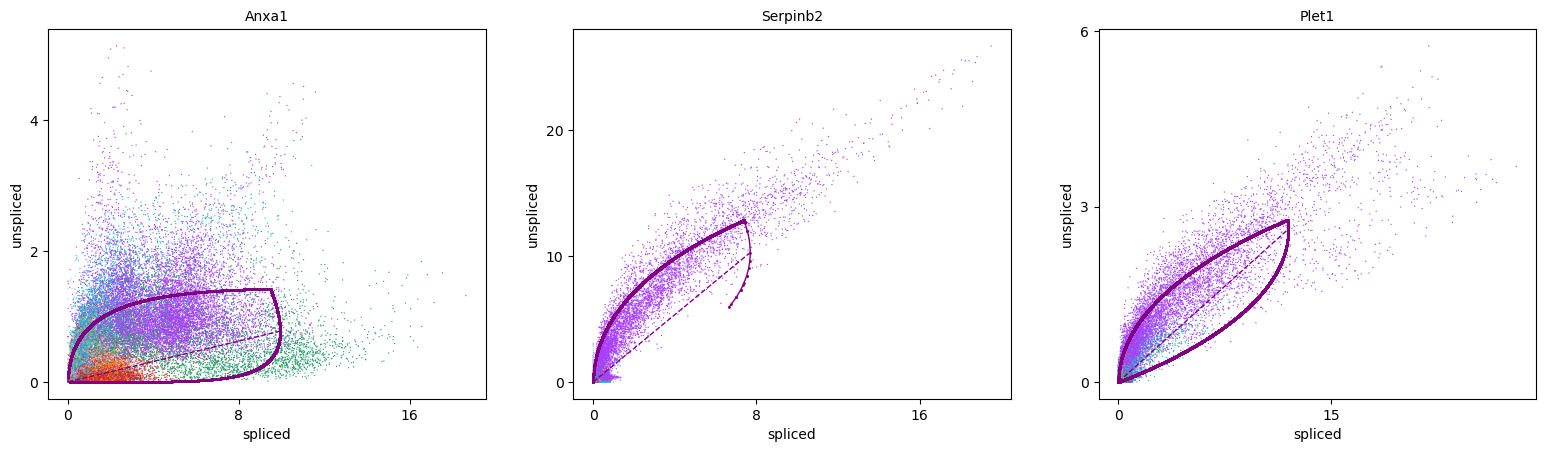

In [23]:
scv.pl.scatter(adata_hvg, color='celltype', basis=adata_hvg.uns["rank_velocity_genes"]["names"]["IFE Keratinocytes"][:3])

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

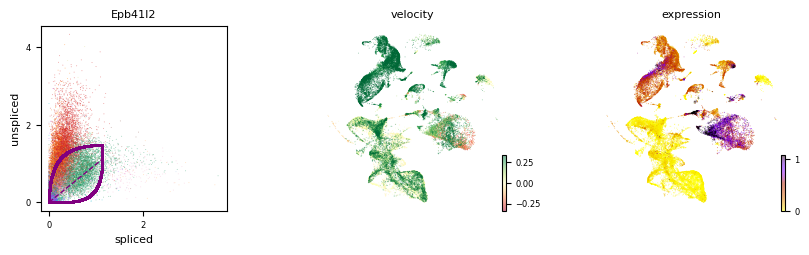

In [24]:
scv.pl.velocity(adata_hvg, ['Epb41l2'], color='celltype')

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

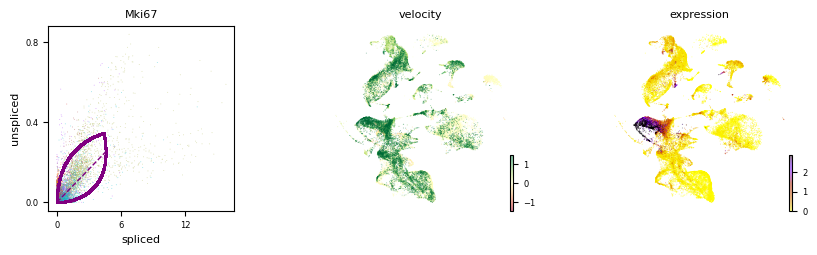

In [25]:
scv.pl.velocity(adata_hvg, ['Mki67'], color='celltype') # Proliferating Keratinocytes

computing terminal states
    identified 9 regions of root cells and 2 regions of end points .
    finished (0:00:10) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:03) --> added 
    'latent_time', shared time (adata.obs)


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

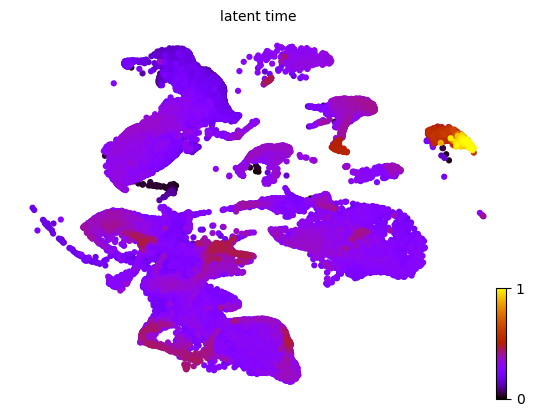

In [26]:
scv.tl.latent_time(adata_hvg)
scv.pl.scatter(adata_hvg, color='latent_time', color_map='gnuplot', size=80)


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


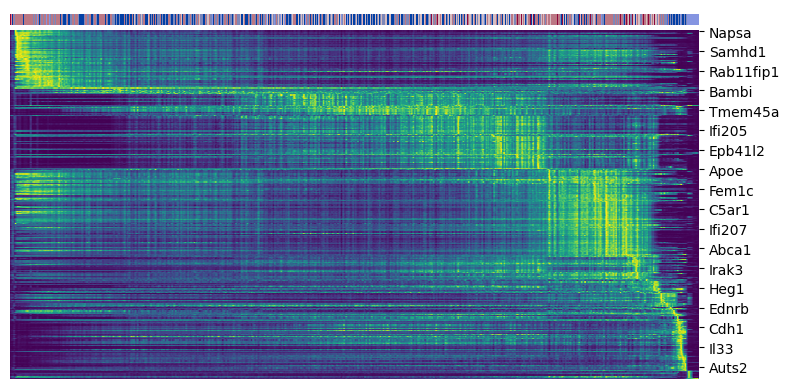

In [27]:
top_genes = adata_hvg.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata_hvg, var_names=top_genes, sortby='latent_time', col_color='metaclusters', n_convolve=100)


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

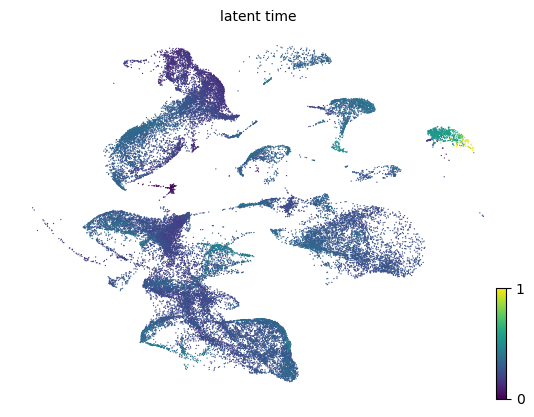

In [33]:
scv.pl.scatter(adata_hvg, color='latent_time', color_map='viridis')

In [28]:
top_genes

Index(['Dmkn', 'Cytip', 'Perp', 'Hmox1', 'Zeb2', 'Fstl1', 'F13a1', 'Serpinb5',
       'Ifi205', 'Oasl1',
       ...
       'Nlrp3', 'Slc7a8', 'Slfn2', 'Actb', 'Igf1', 'Emilin2', 'Tnfaip6',
       'Kitl', 'Col6a2', 'Fcgrt'],
      dtype='object', length=300)

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

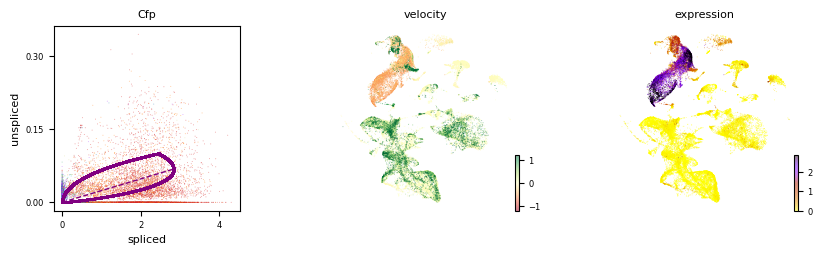

In [29]:
scv.pl.velocity(adata_hvg, ['Cfp'], color='celltype')

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

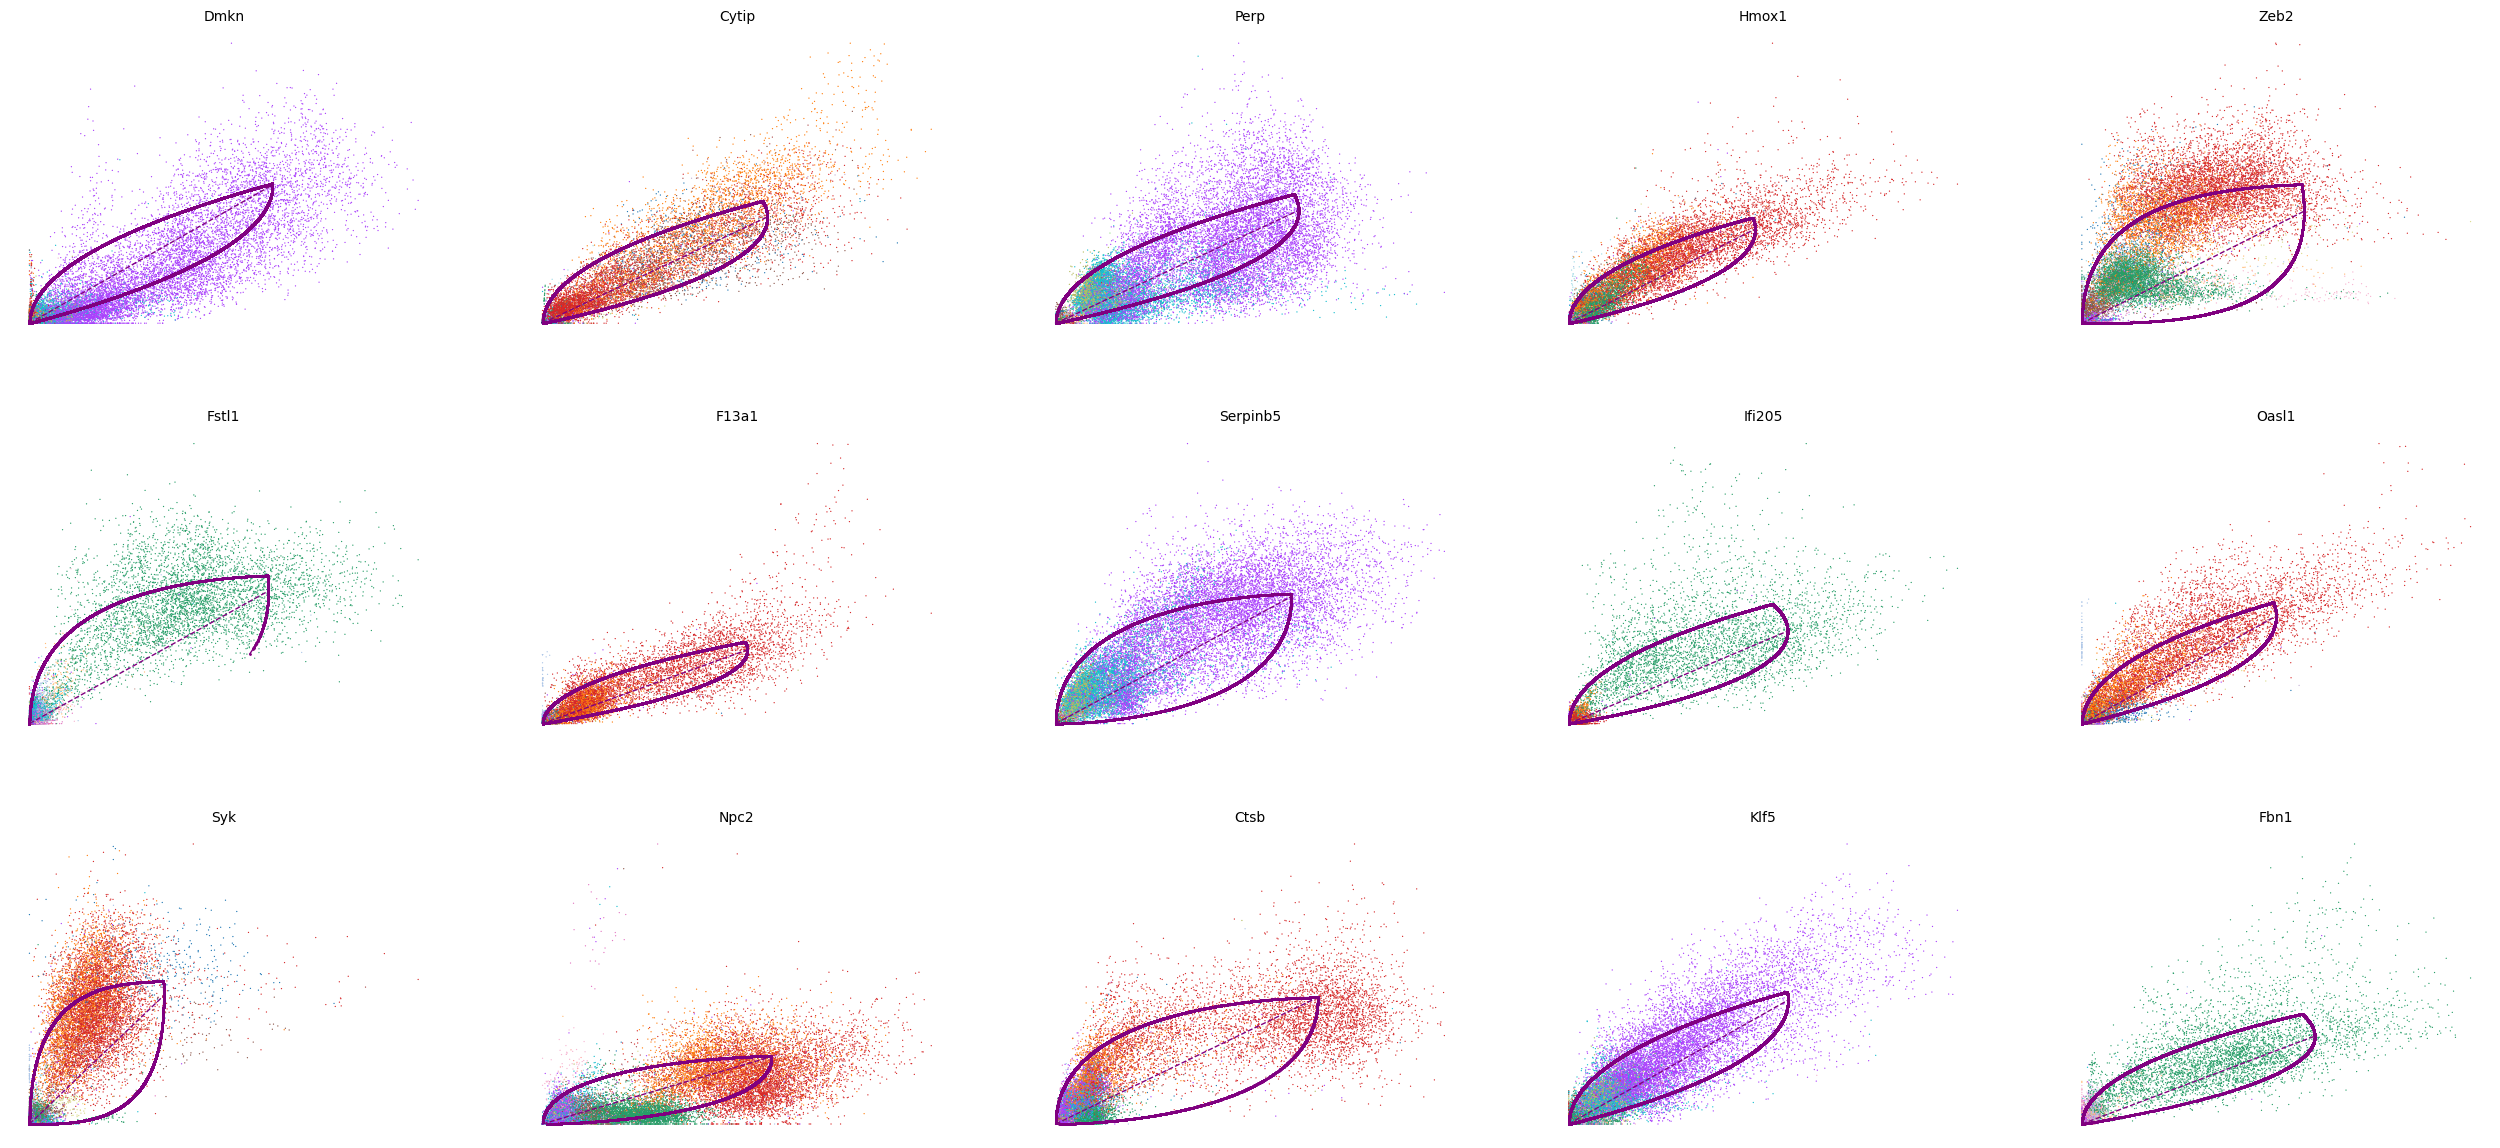

In [30]:
top_genes = adata_hvg.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata_hvg, basis=top_genes[:15], ncols=5, frameon=False, color='celltype',)

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

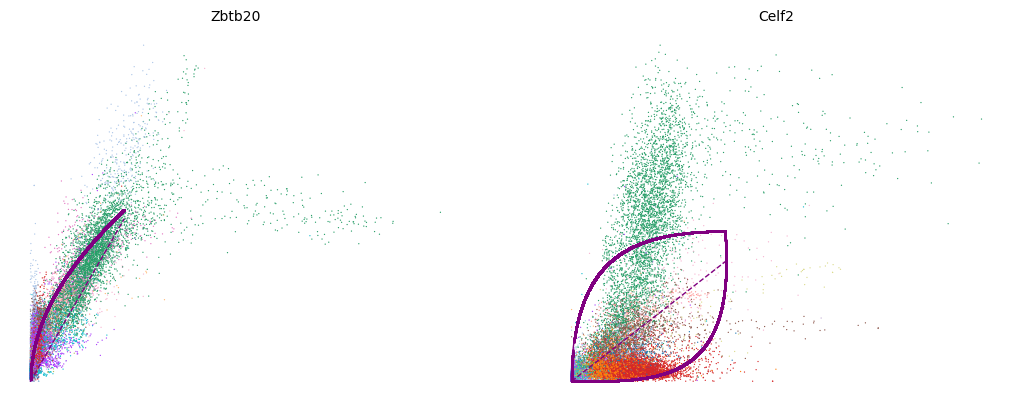

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

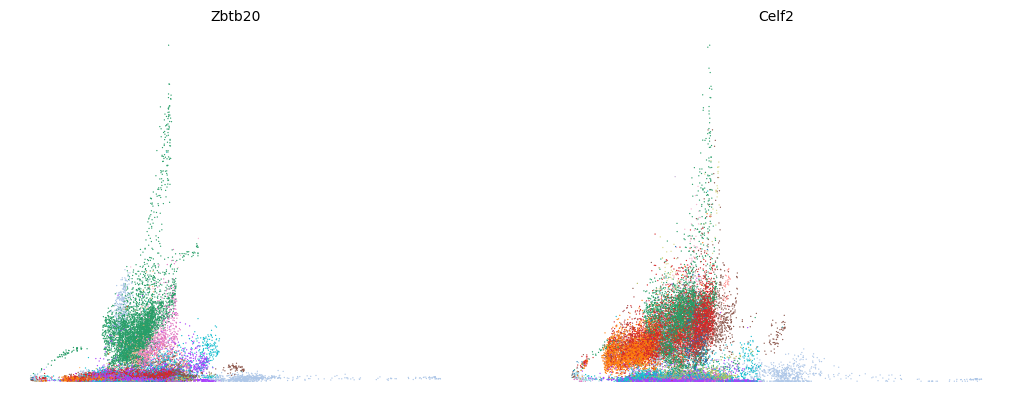

In [31]:
var_names = ['Zbtb20', 'Celf2']
scv.pl.scatter(adata_hvg, var_names, frameon=False, color='celltype',)
scv.pl.scatter(adata_hvg, x='latent_time', y=var_names, frameon=False, color='celltype',)